<a href="https://colab.research.google.com/github/jaalvalcan/GEE_index_sets/blob/main/NDVI_London.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
ee.Authenticate()
ee.Initialize(project='ee-jaalvalcan')

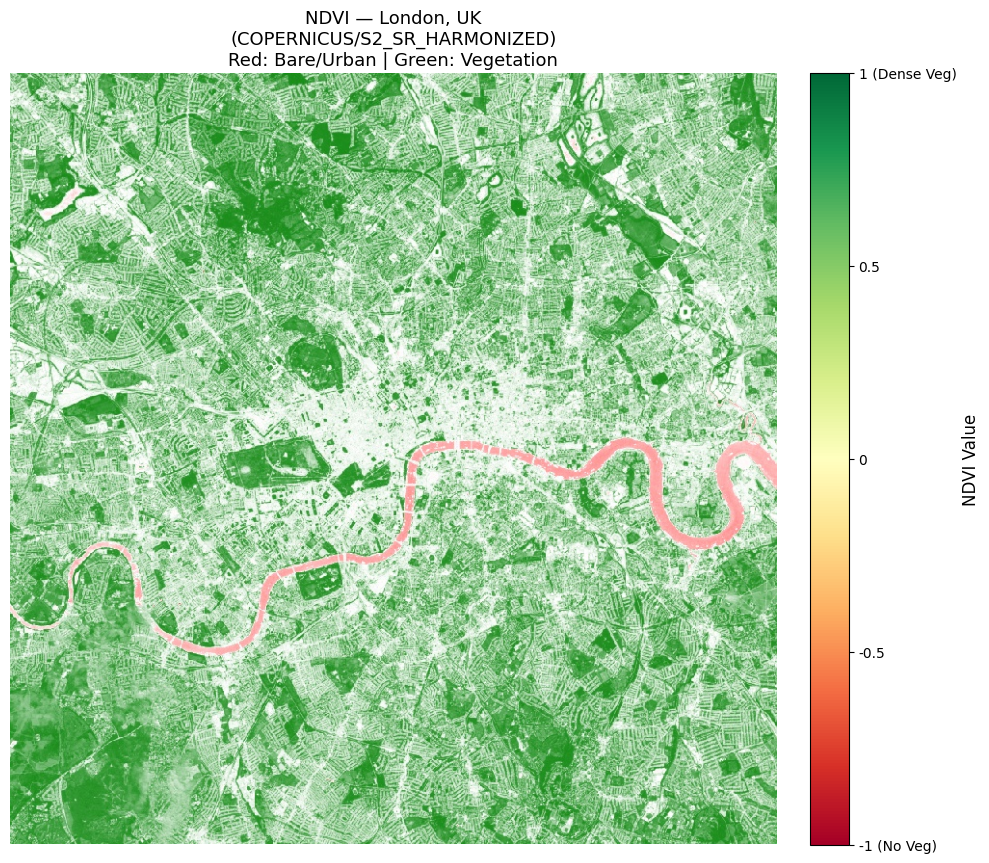


📅 Acquisition Date: 2024-07-31
☁️ Cloud Coverage: 0.151866
🛰️ Satellite: Sentinel-2A


In [ ]:
import ee
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image
from io import BytesIO
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


# Define London region
london_coords = [-0.1276, 51.5072]  # Longitude, Latitude
london_point = ee.Geometry.Point(london_coords)
london_buffer = london_point.buffer(10000)  # 10 km radius

# Load Harmonized Sentinel-2 Surface Reflectance Collection
collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
              .filterBounds(london_buffer)
              .filterDate('2024-04-01', '2024-09-01')  # Adjust as needed
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)))

# Get the least cloudy image
image = collection.sort('CLOUDY_PIXEL_PERCENTAGE').first()

# Calculate NDVI: (NIR - Red) / (NIR + Red)
ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Visualization parameters
vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'white', 'green'],  # Low to high vegetation
    'dimensions': 800,
    'region': london_buffer
}

# Get thumbnail URL and load as numpy array for plotting with colorbar
url = ndvi.getThumbUrl(vis_params)
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img_array = np.array(img)  # Convert to numpy for matplotlib

# Create plot with colorbar legend
fig, ax = plt.subplots(figsize=(10, 10))

# Display image
im = ax.imshow(img_array)

# Create a colorbar legend
norm = Normalize(vmin=-1, vmax=1)
cmap = plt.cm.RdYlGn  # Same as ['red', 'white', 'green'] palette
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Only needed for older matplotlib versions

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('NDVI Value', fontsize=12)
cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
cbar.ax.set_yticklabels(['-1 (No Veg)', '-0.5', '0', '0.5', '1 (Dense Veg)'])

# Customize plot
ax.set_title("NDVI — London, UK\n(COPERNICUS/S2_SR_HARMONIZED)\nRed: Bare/Urban | Green: Vegetation", fontsize=13)
ax.axis('off')

plt.tight_layout()
plt.show()

# Print image info
print("\n📅 Acquisition Date:", image.date().format('YYYY-MM-dd').getInfo())
print("☁️ Cloud Coverage:", image.get('CLOUDY_PIXEL_PERCENTAGE').getInfo())
print("🛰️ Satellite:", image.get('SPACECRAFT_NAME').getInfo())
